In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math

### Designing the Kalman Filter

Modelling as,

$$ X_{t+1} = A_{t}X_{t} + B_{t}U_{t} + \epsilon_{t} $$
$$ Z_t = C_{t}X_{t} + \delta_{t} $$

In [96]:
def parameters(T=200):
    A = np.identity(4)
    A[0,2], A[1,3] = 1,1                              # VERIFY THIS!!! (Time steps are not included!)

    B = np.array([[1/2,0],[0,1/2],[1,0],[0,1]])     # VERIFY THIS!!!  (Should be 1/2 * a * t^2 )

    meu_q = np.zeros((4))
    cov_q = np.identity(4)
    cov_q[2,2],cov_q[3,3] = 0.0001,0.0001
    # To genrate => ep = np.random.multivariate_normal(meu_q,cov_q,N)

    C = np.array([[1,0,0,0],[0,1,0,0]])
    meu_r = np.zeros((2))
    cov_r = 100*np.identity(2)
    # To genrate => ep = np.random.multivariate_normal(meu_r,cov_r,N)

    #T = 200     # Total time steps
    
    return (A,B,meu_q,cov_q,C,meu_r,cov_r,T)

# A,B,meu_q,cov_q,C,meu_r,cov_r,T = parameters()
# params = parameters()

### 2. (a)  Simulate motion and sensor model, and plot the actual and observed trajectory.

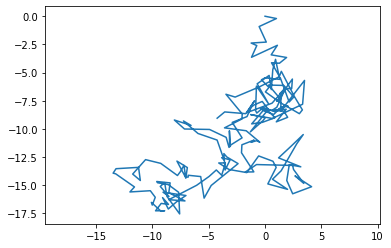

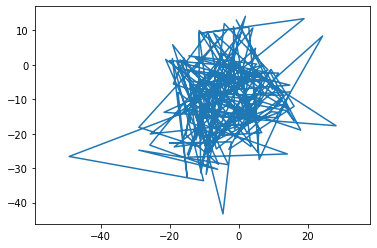

In [97]:
def zero_initializer():
    del_xy = np.zeros((T,2))
    X = np.zeros((4))
    return(del_xy,X)


def time_series(U, X_init , params):
    
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params

    # Assuming deltax and deltay are 0         # CAN/DO WE MAKE THIS ASSUMPTION
    del_xy = U
    
    ep_q = np.random.multivariate_normal(meu_q,cov_q)
    ep_r = np.random.multivariate_normal(meu_r,cov_r)
    
    X = np.zeros((T,4))
    X[0,:] = X_init
    X_obs = np.zeros((T,2))
    X_obs[0,:] = np.dot(C,X[0,:]) + ep_r
    
    
    
    X_obs[0,:] = np.random.multivariate_normal(meu_r,cov_r)


    for i in range(1,T):
        ep_q = np.random.multivariate_normal(meu_q,cov_q)
        X[i,:] = np.dot(A,X[i-1,:])+np.dot(B,del_xy[i-1,:]) + ep_q

        ep_r = np.random.multivariate_normal(meu_r,cov_r)
        X_obs[i,:] = np.dot(C,X[i,:]) + ep_r
    
    return (X,X_obs)

def plotter(X):

    x, y = X[:,0],X[:,1]
    plt.plot(x, y)
    plt.axis('equal')
    plt.show()


params = parameters()
del_xy,X_init = zero_initializer()
X,X_obs = time_series(del_xy,X_init,params)
plotter(X)
plotter(X_obs)

### 2.(b) Estimation of Vehicle state
We use Kalman filter form of Baye's filter for the implementing the estimation of the vehicle's state.

As mentioned before, modelling as,

$$ X_{t+1} = A_{t}X_{t} + B_{t}U_{t} + \epsilon_{t} $$
$$ Z_t = C_{t}X_{t} + \delta_{t} $$

###### Dynamic Update:
$$ \bar{\mu} = A*X\_bel\_\mu_{i-1} + B*U $$
$$ \bar{\Sigma} = A*X\_bel\_\Sigma_{i-1}*A^{T} + Cov\_matrix(\epsilon_{t}) $$

###### Measurement Update:
$$ R = \bar{\Sigma}C^{T}(C\bar{\Sigma}C^{T}+R) + Cov\_matrix(\delta_{t})$$
$$ X\_bel\_\mu_{i} = \bar{\mu} + K(Z_{t}-C\bar{\mu}) $$
$$ X\_bel\_\Sigma_{i} = (I - KC)\bar{\Sigma} $$

In [98]:
params = parameters()
del_xy,X_init = zero_initializer()
X_init = np.array([10,10,1,1])
X,X_obs = time_series(del_xy,X_init,params)

In [99]:
def Kalman_Filter(meu_prev,cov_prev,U,Z,params):
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params
    # Dynamics Update:
    meu_temp = np.dot(A,meu_prev) + np.dot(B,U)
    cov_temp = np.dot(np.dot(A,cov_prev),A.T) + cov_q
    # Measurement Update:
    K = np.dot( np.dot( cov_temp,C.T ) , np.linalg.inv( np.dot(np.dot(C,cov_temp),C.T) + cov_r) )
    meu = meu_temp + np.dot(K,Z-np.dot(C,meu_temp))
    KC_calc = np.dot(K,C)
    cov = np.dot(np.identity(KC_calc.shape[0]) - KC_calc , cov_temp)
    
    return (meu,cov)
    
def state_estimation(U , X , X_obs , params):
    
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params
    
    X_init = X[0,:]
    X_belief_meu = np.zeros((T,X.shape[1]))
    X_belief_cov = np.zeros((T,X.shape[1],X.shape[1]))
    
    #X_belief_meu[0,:] = np.random.multivariate_normal(X_init , 0.0001*np.identity(4))
    X_belief_meu[0,:] = X_init
    X_belief_cov[0,:] = 0.0001*np.identity(X.shape[1])
    
    for i in range(1,T):
        X_belief_meu[i,:],X_belief_cov[i,:] = Kalman_Filter(X_belief_meu[i-1,:],
                                                            X_belief_cov[i-1,:],
                                                            U[i-1,:],X_obs[i-1],params)
        
    return (X_belief_meu,X_belief_cov)

X_pred_meu,X_pred_cov = state_estimation(del_xy , X , X_obs , params)


### 2.(c) Plot the Actual Trajectory, Noisy Observations, Estimated Tragectory (produced by filter). Also plot, uncertainty ellipse for the estimated trajectory
An uncertainty ellipse denotes the locus of points that are one standard deviation away from the mean.

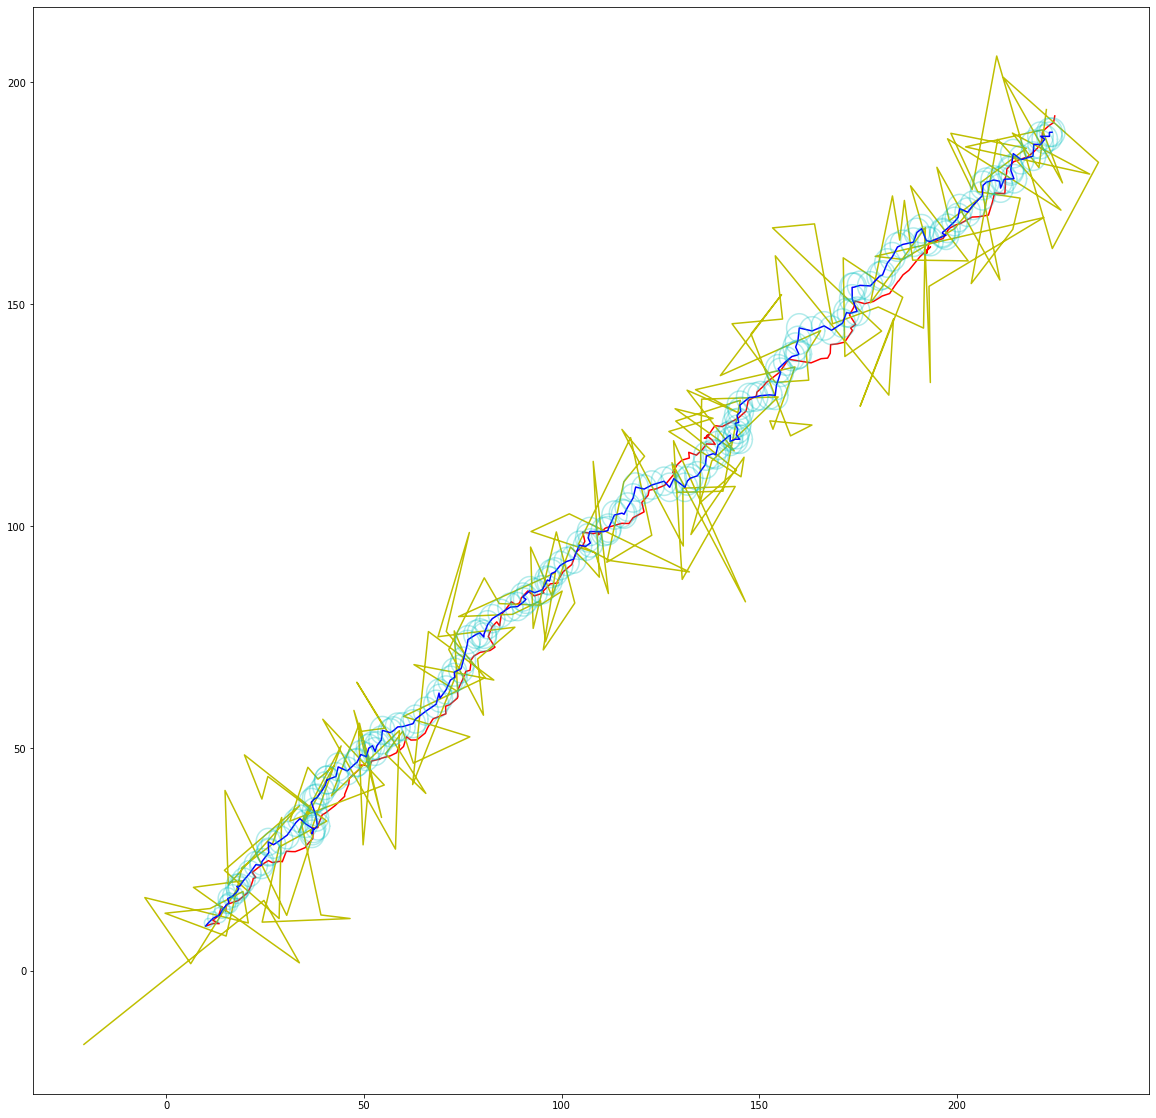

In [100]:
def ellipse_plotter(x,y,rx,ry,clr='c',a=0.3):
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = x+rx*np.cos(theta)
    x2 = y+ry*np.sin(theta)
    plt.plot(x1,x2,color=clr,alpha=a)

def uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_cov):
    for i in range(X.shape[0]):
        ellipse_plotter( X_pred_meu[i,0],X_pred_meu[i,1]
                       ,math.sqrt(X_pred_cov[i,0,0])
                       ,math.sqrt(X_pred_cov[i,1,1]))

    
    
def multiplotter(X1,X2,X3):
    x1, y1 = X1[:,0],X1[:,1]
    x2, y2 = X2[:,0],X2[:,1]
    x3, y3 = X3[:,0],X3[:,1]
    plt.figure(figsize=(20, 20))
    plt.plot(x1, y1, color='r')
    plt.plot(x2, y2, color='y')
    plt.plot(x3, y3, color='b')
    

multiplotter(X,X_obs,X_pred_meu)
uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_var)
plt.show()

### 2.(d) Implement Control Policy. Plot true, observed, estimated trajectories. Compute and plot error-
Implement a control policy where $\delta \dot{x_t}$ varies as a sine wave and $\delta \dot{y_t}$ varies as a cosine wave. Plot the true, observed and the estimated $x_{t}$, $y_{t}$ trajectories under the given control inputs. Compute and plot the error between the true and the estimated trajectory using the euclidean distance metric.


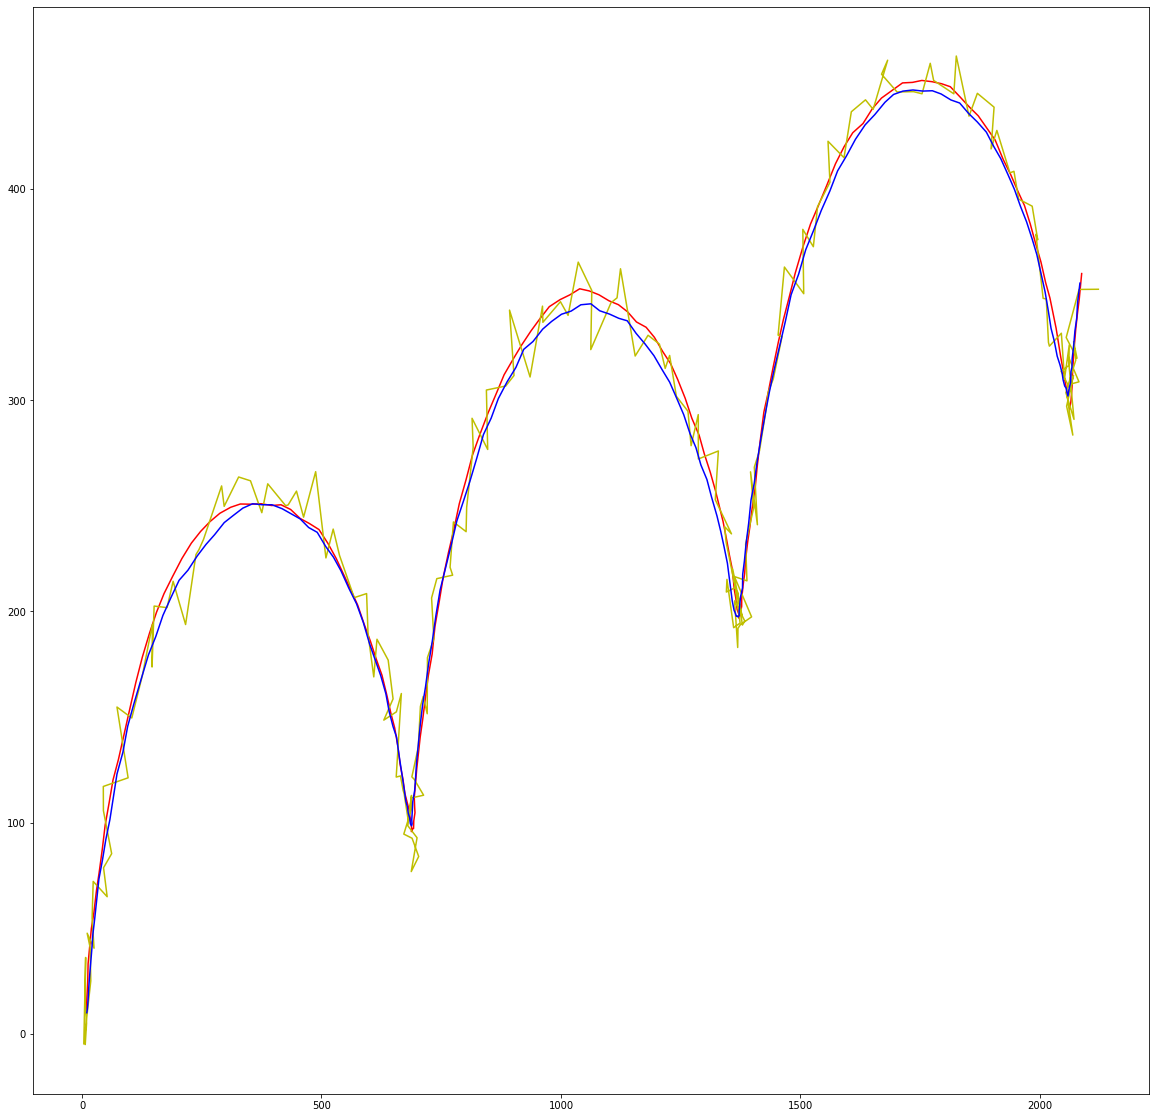

In [107]:
def sin_cos_init():
    sinusoid_producers = 0.1*np.arange(T)
    del_xy = np.hstack((np.sin(sinusoid_producers).reshape(-1,1),np.cos(sinusoid_producers).reshape(-1,1)))
    return del_xy


params = parameters(200)
A,B,meu_q,cov_q,C,meu_r,cov_r,T = params

del_xy = sin_cos_init()
X_init = np.array([10,10,1,1])

X,X_obs = time_series(del_xy,X_init,params)
X_pred_meu,X_pred_cov = state_estimation(del_xy , X , X_obs , params)
multiplotter(X,X_obs,X_pred_meu)
#uncertain_ellipse(X,X_obs,X_pred_meu,X_pred_var)
plt.show()

### 2.(e) Experiment with changes in uncertainty in sensor model-
Increase and decrease the uncertainty in the sensor model in comparison with the uncertainty in the motion model. Plot the estimated trajectory and explain how the noise variation impacts the filter performance.

### 2.(f) Experiment with changes in uncertainty in initial belief-
Next, model higher uncertainty in the initial belief over the vehicle’s position assuming a standard deviation of 100 in both the x and y positions. As before, plot the true, observed and the estimated trajectories under the sine-cosine control policy.

### 2.(g) ???
Assume that the sensor observations drop out at time instants t = 10 and t = 30 for a period of 10
time steps and are re-acquired after that period. Simulate and show the evolution of uncertainty in
the vehicle’s ($x_t$, $y_t$) position by plotting the uncertainty ellipses.

### 2.(h) Velocity plot
Plot the estimated velocities ($\hat{\dot{x}}$, $\hat{\dot{y}}$) and the true velocities of the vehicle ($\dot{x_{t}}$, $\dot{y_{t}}$). Briefly explain if the estimator can or cannot track the true values.

### 2.(i) Multi-agent modelling